In [ ]:
# Author: Dafne Vania Peña Cortés
# This program uses EfficientNetB4 to classify images
# in 5 categories: I1, F1, R0, F2 and I2.
# [Step 3]

In [ ]:
!python --version
!pip show tensorflow

Python 3.8.16
Name: tensorflow
Version: 2.9.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.8/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: kapre


In [ ]:
import os
import cv2
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive
from pathlib import Path

In [ ]:
it = {"I1": [146, 164], "F1": [181, 187],
      "R0": [200, 228], "F2": [238, 243],
      "I2": [280, 290]}
vidFinSec = 362

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 180,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 5,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ['F1', 'F2', 'I1', 'I2', 'R0'],
}

img_dir = "/content/img_face_recordings/"

In [ ]:
!unzip "/content/img_face_recordings_niceEEGs.zip" -d "/content/"
#rmdir /content/img_face_recordings/.ipynb_checkpoints

Se han truncado las últimas 5000 líneas del flujo de salida.
 extracting: /content/img_face_recordings/I2/Re_Face_IsraelLezama_2022-11-08-11_08_29_027.jpeg  
 extracting: /content/img_face_recordings/I2/Re_Face_IsraelLezama_2022-11-08-11_08_29_028.jpeg  
 extracting: /content/img_face_recordings/I2/Re_Face_IsraelLezama_2022-11-08-11_08_29_029.jpeg  
 extracting: /content/img_face_recordings/I2/Re_Face_IsraelLezama_2022-11-08-11_08_29_030.jpeg  
 extracting: /content/img_face_recordings/I2/Re_Face_IsraelLezama_2022-11-08-11_08_29_031.jpeg  
 extracting: /content/img_face_recordings/I2/Re_Face_IsraelLezama_2022-11-08-11_08_29_032.jpeg  
 extracting: /content/img_face_recordings/I2/Re_Face_IsraelLezama_2022-11-08-11_08_29_033.jpeg  
 extracting: /content/img_face_recordings/I2/Re_Face_IsraelLezama_2022-11-08-11_08_29_034.jpeg  
 extracting: /content/img_face_recordings/I2/Re_Face_IsraelLezama_2022-11-08-11_08_29_035.jpeg  
 extracting: /content/img_face_recordings/I2/Re_Face_IsraelLezama_

In [ ]:
trn_ds = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=27,
    validation_split=0.25,
    subset='training'
)
vld_ds = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=27,
    validation_split=0.25,
    subset='validation'
)

Found 10482 files belonging to 5 classes.
Using 7862 files for training.
Found 10482 files belonging to 5 classes.
Using 2620 files for validation.


In [ ]:
# complete_dataset = tf.keras.utils.image_dataset_from_directory(
#     img_dir,
#     labels='inferred',
#     label_mode='categorical',
#     class_names=CONFIGURATION["CLASS_NAMES"],
#     color_mode='grayscale',
#     batch_size=CONFIGURATION["BATCH_SIZE"],
#     image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
#     shuffle=True,
#     seed=27
# )
# spl = tfds.even_splits('train', n=10, drop_remainder=True)
# # Load 1/10 of the train split.
# example_split = tfds.load(complete_dataset, split=spl[0])

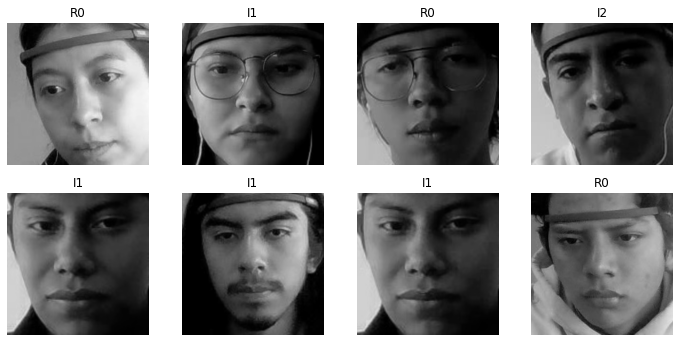

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in trn_ds.take(1):
  for i in range(8):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

In [ ]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (-0.05, 0.05)),
       RandomFlip(mode='horizontal',),
       RandomContrast(factor=0.1),                   
])

In [ ]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [ ]:
trn_ds = (
    trn_ds
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
vld_ds = (
    vld_ds
    # .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),                 
])

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 [==============================] - 4s 0us/step


In [ ]:
backbone.trainable = False

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),
    
    ])
pretrained_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1836032   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 5)                

In [ ]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [ ]:
pretrained_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [ ]:
history = pretrained_model.fit(
  trn_ds,
  validation_data = vld_ds,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/180
246/246 [==============================] - 108s 362ms/step - loss: 1.2197 - accuracy: 0.5600 - top_k_accuracy: 0.7736 - val_loss: 1.0543 - val_accuracy: 0.5813 - val_top_k_accuracy: 0.8095
Epoch 2/180
246/246 [==============================] - 87s 352ms/step - loss: 0.8681 - accuracy: 0.6777 - top_k_accuracy: 0.8636 - val_loss: 0.8733 - val_accuracy: 0.6721 - val_top_k_accuracy: 0.8847
Epoch 3/180
246/246 [==============================] - 86s 348ms/step - loss: 0.7574 - accuracy: 0.7181 - top_k_accuracy: 0.8968 - val_loss: 0.7503 - val_accuracy: 0.7168 - val_top_k_accuracy: 0.8969
Epoch 4/180
246/246 [==============================] - 86s 347ms/step - loss: 0.6754 - accuracy: 0.7544 - top_k_accuracy: 0.9121 - val_loss: 0.6760 - val_accuracy: 0.7687 - val_top_k_accuracy: 0.9107
Epoch 5/180
246/246 [==============================] - 87s 350ms/step - loss: 0.6300 - accuracy: 0.7723 - top_k_accuracy: 0.9215 - val_loss: 0.6989 - val_accuracy: 0.7531 - val_top_k_accuracy: 0.9115

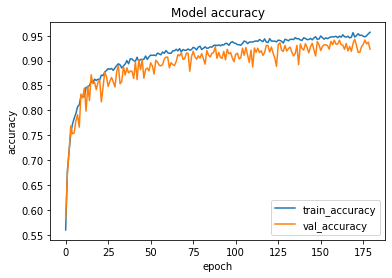

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

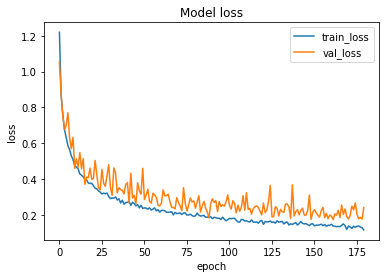

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()